In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20221125_mm_bf'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
symbols = ['BTC']
# symbols = ['ETH']
# symbols = ['MATIC']
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'AVAX'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            # 'table': 'binance_ohlcv_5m',
            'table': 'bf_ohlcv_5m',
            # 'symbols': ['{}USDT'.format(x) for x in symbols],
            'symbols': ['FX_{}_JPY'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def estimate_pips(x, window=None, reverse=False):
    if reverse:
        return estimate_pips(x[::-1], window=window)[::-1]
    scale = 10 ** 8
    x = np.round(x * scale).astype(np.compat.long)
    if x.ndim != 1:
        x = np.gcd.reduce(x, axis=1)
    x2 = x.copy()
    for i in range(1, window):
        x2[i:] = np.gcd(x2[i:], x[:-i])
    return x2 * 1.0 / scale

def merge_data(dfs):
    # single symbol
    df = dfs[0]
    df = df.sort_values(['timestamp', 'symbol'])
    df['symbol'] = df['symbol'].str.replace('FX_', '').str.replace('_JPY', '')
    df['pips'] = estimate_pips(df[['op', 'hi', 'lo', 'cl']].values, window=100)
    time_shift = -10
    # floor_freq = '4H'
    floor_freq = '1H'
    # floor_freq = '15min'
    
    df['timestamp_shift'] = df['timestamp'] - pd.to_timedelta(5, unit='minute')
    # df['timestamp_shift'] = df['timestamp'] - pd.to_timedelta(10, unit='minute')
    # df['timestamp_shift'] = df['timestamp'] - pd.to_timedelta(15, unit='minute')
    df['timestamp'] = (df['timestamp'] - pd.to_timedelta(time_shift, unit='minute')).dt.floor(floor_freq) + pd.to_timedelta(time_shift, unit='minute')
    df['timestamp_shift'] = (df['timestamp_shift'] - pd.to_timedelta(time_shift, unit='minute')).dt.floor(floor_freq) + pd.to_timedelta(time_shift, unit='minute')
    
    df = pd.concat([
        df.groupby('timestamp')['op'].nth(0),
        df.groupby('timestamp')['cl'].nth(-1),
        df.groupby('timestamp')['hi'].max(),
        df.groupby('timestamp')['lo'].min(),
        df.groupby('timestamp')['pips'].nth(-1),
        df.groupby('timestamp')['symbol'].nth(-1),
        df.groupby('timestamp')['volume'].sum(),
        df.groupby('timestamp_shift')['cl'].nth(-1).rename('cl_shift'),
        df.groupby('timestamp_shift')['hi'].max().rename('hi_shift'),
        df.groupby('timestamp_shift')['lo'].min().rename('lo_shift'),
        df.groupby('timestamp_shift')['cl'].mean().rename('twap_5m_shift'),
    ], axis=1)
    df = df.dropna()
    df.index.rename('timestamp', inplace=True)
    df = df.reset_index()
    # display(df)
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

# df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_mm.pkl')
display(df)

,op,hi,lo,cl,volume,amount,trades,buy_volume,buy_amount,twap,timestamp,symbol
0,2310253.0,2310757.0,2309794.0,2309836.0,7.214032,1.666663e+07,303,3.571913,8.252614e+06,2310165.0,2022-12-02 16:10:00+00:00,FX_BTC_JPY
1,2309836.0,2310096.0,2308275.0,2308453.0,9.867514,2.278552e+07,416,4.037622,9.323666e+06,2308944.0,2022-12-02 16:15:00+00:00,FX_BTC_JPY
2,2300570.0,2301634.0,2299529.0,2299728.0,9.954034,2.289908e+07,512,4.983578,1.146487e+07,2300390.8,2022-12-02 07:50:00+00:00,FX_BTC_JPY
3,2303788.0,2304137.0,2302690.0,2303356.0,5.925737,1.364827e+07,257,2.842939,6.547996e+06,2303393.2,2022-12-02 05:30:00+00:00,FX_BTC_JPY
4,2302128.0,2303231.0,2300385.0,2300826.0,18.762817,4.318360e+07,769,6.901427,1.588587e+07,2301824.0,2022-12-02 07:05:00+00:00,FX_BTC_JPY
...,...,...,...,...,...,...,...,...,...,...,...,...
340530,1149028.0,1152632.0,1146747.0,1148485.0,939.653027,1.080530e+09,16895,503.332418,5.788655e+08,1149752.2,2019-09-13 08:10:00+00:00,FX_BTC_JPY
340531,900212.0,909000.0,899951.0,908161.0,1733.096561,1.568647e+09,17151,922.658008,8.351551e+08,905795.6,2020-05-10 17:05:00+00:00,FX_BTC_JPY
340532,971894.0,975241.0,971085.0,973039.0,1344.606817,1.308394e+09,17919,696.705106,6.780337e+08,973121.8,2020-01-14 15:50:00+00:00,FX_BTC_JPY
340533,788211.0,796759.0,787481.0,791202.0,1446.881070,1.146633e+09,18687,761.506255,6.035715e+08,792334.4,2019-11-22 11:00:00+00:00,FX_BTC_JPY


,,op,cl,hi,lo,pips,volume,cl_shift,hi_shift,lo_shift,twap_5m_shift
timestamp,symbol,,,,,,,,,,
2019-08-29 23:50:00+00:00,BTC,1040192.0,1034195.0,1044560.0,1031850.0,1.0,3232.442091,1035352.0,1044560.0,1031850.0,1.035610e+06
2019-08-30 00:50:00+00:00,BTC,1034195.0,1034894.0,1036796.0,1025320.0,1.0,5070.089815,1036278.0,1036475.0,1025320.0,1.032476e+06
2019-08-30 01:50:00+00:00,BTC,1034894.0,1034780.0,1038000.0,1033364.0,1.0,2103.809466,1034799.0,1038000.0,1033364.0,1.035105e+06
2019-08-30 02:50:00+00:00,BTC,1034779.0,1037023.0,1039747.0,1032633.0,1.0,2004.876297,1037202.0,1039747.0,1032633.0,1.036286e+06
2019-08-30 03:50:00+00:00,BTC,1037022.0,1038793.0,1041413.0,1036000.0,1.0,2263.394501,1039627.0,1041413.0,1036000.0,1.038416e+06
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-02 11:50:00+00:00,BTC,2300281.0,2304368.0,2309327.0,2298052.0,1.0,173.555020,2304370.0,2309327.0,2298052.0,2.303153e+06
2022-12-02 12:50:00+00:00,BTC,2304036.0,2309302.0,2316603.0,2292850.0,1.0,823.335429,2308559.0,2316603.0,2292850.0,2.310587e+06
2022-12-02 13:50:00+00:00,BTC,2309830.0,2309144.0,2315784.0,2303027.0,1.0,393.038293,2310523.0,2315784.0,2303027.0,2.308264e+06


In [3]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_mm.pkl')
df = df.reset_index(level=1, drop=True)

print(pearsonr(df['cl_shift'] - df['cl'], (df['cl'].shift(-1) - df['cl_shift']).fillna(0)))

w = 24
dist = (df['hi'].rolling(w).max() - df['lo'].rolling(w).min()).fillna(0) / w ** 0.5 * 0.3
# center = df['cl']
center = df['cl_shift']

df['buy_price'] = ((center - dist) / df['pips']).round() * df['pips']
df['buy_price'] = np.minimum(df['buy_price'], df['cl_shift'] - df['pips'])
df['sell_price'] = ((center + dist) / df['pips']).round() * df['pips']
df['sell_price'] = np.maximum(df['sell_price'], df['cl_shift'] + df['pips'])

df['buy_exec'] = 1.0 * (df['buy_price'] > df['lo_shift'].shift(-1))
df['sell_exec'] = 1.0 * (df['sell_price'] < df['hi_shift'].shift(-1))
# df['ret_buy'] = (df['cl_shift'].shift(-1) / df['buy_price'] - 1) * df['buy_exec']
# df['ret_sell'] = -(df['cl_shift'].shift(-1) / df['sell_price'] - 1) * df['sell_exec']
df['ret_buy'] = (df['twap_5m_shift'].shift(-2) / df['buy_price'] - 1) * df['buy_exec']
df['ret_sell'] = -(df['twap_5m_shift'].shift(-2) / df['sell_price'] - 1) * df['sell_exec']

df.to_pickle('/tmp/df_mm.pkl')

(-0.021018916128040636, 0.0003848563400817185)


0.0003126127732842463
0.009523478979281439
0.5734768281567693
8.497526236587269e-05
0.008818962523014708
0.5797167496319148


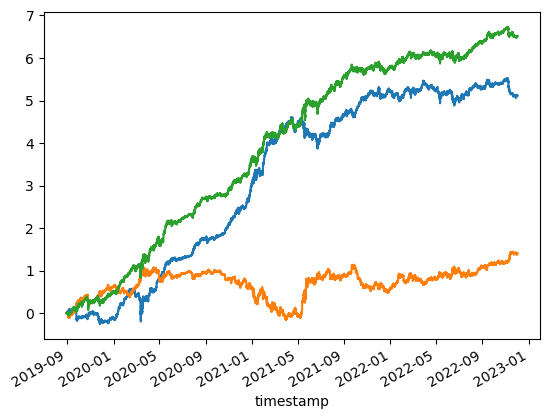

In [4]:
df = pd.read_pickle('/tmp/df_mm.pkl')

df['ret_buy'].cumsum().plot()
df['ret_sell'].cumsum().plot()
(df['ret_buy'] + df['ret_sell']).cumsum().plot()

for col in ['ret_buy', 'ret_sell']:
    print(df.loc[df[col] != 0, col].mean())
    print(df.loc[df[col] != 0, col].std())
    print(np.mean(df[col] != 0))

In [5]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    # df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    # df['beta'] = 1.0
    
#     dfs = [
#         df,
#         # df.drop(columns=get_feature_columns(df)),
#     ]
    
#     if with_ret:
#         ret_mean = beta_mean(df, 'ret')
#         dfs += [
#             (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
#             (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
#         ]
    
#     for col in get_feature_columns(df):
#         feature_mean = beta_mean(df, col)
#         dfs += [
#             (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
#             (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
#         ]
#     df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return -skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    # for t_center in [2, 4, 6, 12, 24]:
    for t_center in [2, 4, 6, 12, 24, 36, 48]:
    # for t_center in [4, 6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NonstationaryFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio

    def fit(self, X, y=None):
        X = self._validate_data(X)
        
        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])
            
        mem = get_joblib_memory()
        self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')

        
def nfr_calc_features(model, remove_count, X):
    model = clone(model)
    model.fit(X, np.arange(X.shape[0]))
    importances = model.feature_importances_

    features = list(range(X.shape[1]))
    feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
    feature_imp = feature_imp.sort_values('value')

    for i in range(X.shape[1] - remove_count, X.shape[1]):
        features.remove(int(feature_imp['feature'].iloc[i]))

    return np.array(features)

In [7]:
from sklearn.base import clone, BaseEstimator
from sklearn.ensemble._base import _set_random_states


class ClusteringBaggingRegressor(BaseEstimator):
    def __init__(self, base_estimator=None, sample_clustering=None, feature_clustering=None, n_estimators=10, max_samples=1.0, random_state=1):
        self.base_estimator = base_estimator
        self.sample_clustering = sample_clustering
        self.feature_clustering = feature_clustering
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state
        
    def fit(self, X, y, sample_weight=None):
        # print(X.shape)
        # display(X)
        
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values
        if sample_weight is not None and hasattr(sample_weight, 'values'):
            sample_weight = sample_weight.values
            
        if sample_weight is not None:
            nonzero = sample_weight != 0
            X = X[nonzero]
            y = y[nonzero]
            sample_weight = sample_weight[nonzero]
            
        rs = np.random.RandomState(self.random_state)
        
            
        mem = get_joblib_memory()
        sample_labels = mem.cache(cbr_clustering)(self.sample_clustering, X)
        feature_labels = mem.cache(cbr_clustering)(self.feature_clustering, X)
        
        if sample_labels is not None:
            _, counts = np.unique(sample_labels, return_counts=True)
            plt.plot(np.sort(counts))
            plt.show()
        _, counts = np.unique(feature_labels, return_counts=True)
        plt.plot(np.sort(counts))
        plt.show()
        
        # better?
        feature_idx = []
        for label in np.unique(feature_labels):
            feature_idx.append(rs.choice(np.arange(X.shape[1])[feature_labels == label], self.n_estimators))
        self.feature_idx_ = np.array(feature_idx)
        
        # df = pd.concat([
        #     pd.Series(feature_labels).rename('feature_label')
        # ], axis=1)
        # df['count'] = df.groupby('feature_label')['feature_label'].transform('count')
        # p = 1.0 / df['count'].values
        # feature_idx = []
        # for label in np.unique(feature_labels):
        #     feature_idx.append(rs.choice(np.arange(X.shape[1]), self.n_estimators, p=p / np.sum(p)))
        # self.feature_idx_ = np.array(feature_idx)
        
        self.estimators_ = []
        for i in range(self.n_estimators):
            est = clone(self.base_estimator)
            _set_random_states(est, rs.randint((1 << 31) - 1))
            
            if sample_labels is None:
                # normal bagging
                # sample_idx = rs.choice(np.arange(X.shape[0]), int(X.shape[0] * self.max_samples))
                sample_idx = np.arange(X.shape[0]) # better?
            else:
                # sample_idx = []
                # for label in np.unique(sample_labels):
                #     sample_idx.append(rs.choice(np.arange(X.shape[0])[sample_labels == label], 1))
                # sample_idx = np.array(sample_idx)
                
                df = pd.concat([
                    pd.Series(sample_labels).rename('sample_label')
                ], axis=1)
                df['count'] = df.groupby('sample_label')['sample_label'].transform('count')
                sample_idx = rs.choice(np.arange(X.shape[0]), int(X.shape[0] * self.max_samples), p=1.0 / df['count'].values)
            
            est.fit(X[sample_idx.reshape(-1, 1), self.feature_idx_[:, i].reshape(1, -1)], y[sample_idx], sample_weight=None if sample_weight is None else sample_weight[sample_idx])
            self.estimators_.append(est)
        
        return self
        
    def predict(self, X):
        if hasattr(X, 'values'):
            X = X.values
        y_preds = []
        for i, est in enumerate(self.estimators_):
            y_preds.append(est.predict(X[:, self.feature_idx_[:, i]]))
        return np.mean(y_preds, axis=0)
    
def cbr_clustering(clustering, X):
    if clustering is None:
        return None
    clustering = clone(clustering)
    clustering.fit(X)
    return clustering.labels_

In [20]:
from sklearn.base import clone
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.cluster import FeatureAgglomeration, AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, QuantileTransformer

class ExampleModelRank:
    def __init__(self):
        # self._model_buy = Ridge(fit_intercept=False, alpha=1e5)
        # self._model_sell = Ridge(fit_intercept=False, alpha=1e5)
        # self._model = Ridge(fit_intercept=True, alpha=1)
        
        # lgbm = Ridge(fit_intercept=True, alpha=1e5)
        
        lgbm = lgb.LGBMRegressor(
            n_estimators=1000,
            # n_estimators=100,
            # learning_rate=0.02,
            learning_rate=0.001,
            # learning_rate=0.01,
            extra_trees=True,
            # colsample_bytree=0.9,
            colsample_bytree=0.5,
            # lambda_l2=1e2,
            # subsample=0.5,
            # subsample_freq=1,
            # boosting='rf',
            # boosting='dart',
            random_state=1,
            n_jobs=-1,
        )
        
        # lgbm = BaggingRegressor(
        #     lgbm,
        #     n_estimators=10,
        #     random_state=1
        # )
        
#         lgbm = ClusteringBaggingRegressor(
#             lgbm,
#             # sample_clustering=KMeans(1000, random_state=1),
#             # sample_clustering=AgglomerativeClustering(10000),
#             feature_clustering=FeatureAgglomeration(20),
#             n_estimators=10,
#         )
        
        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        lgbm = Pipeline([
            # ('remove_nonstationary1', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            # )),
            # ('remove_nonstationary2', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            # )),
            # ('sc', StandardScaler(with_mean=False)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='normal', random_state=1)),
            ('model', lgbm)
        ])
        
        self._model_buy = clone(lgbm)
        self._model_sell = clone(lgbm)
        self._model_hi = clone(lgbm)
        self._model_lo = clone(lgbm)
        self._model_cl = clone(lgbm)
        self._model_total = clone(lgbm)
        
        # self._model_hi = BaggingRegressor(
        #     self._model_hi,
        #     n_estimators=10,
        #     # max_samples=0.9,
        #     # bootstrap=False,
        #     # max_features=0.9,
        #     random_state=1
        # )
        # self._model_lo = BaggingRegressor(
        #     self._model_lo,
        #     n_estimators=10,
        #     # max_samples=0.9,
        #     # bootstrap=False,
        #     # max_features=0.9,
        #     random_state=1
        # )
        # self._model_cl = BaggingRegressor(
        #     self._model_cl,
        #     n_estimators=10,
        #     # max_samples=0.9,
        #     # bootstrap=False,
        #     # max_features=0.9,
        #     random_state=1
        # )
        # self._model_buy = BaggingRegressor(
        #     self._model_buy,
        #     n_estimators=10,
        #     # max_samples=0.9,
        #     # bootstrap=False,
        #     # max_features=0.9,
        #     random_state=1
        # )
        # self._model_sell = BaggingRegressor(
        #     self._model_sell,
        #     n_estimators=10,
        #     # max_samples=0.9,
        #     # bootstrap=False,
        #     # max_features=0.9,
        #     random_state=1
        # )
        # self._model_total = BaggingRegressor(
        #     self._model_total,
        #     n_estimators=10,
        #     # max_samples=0.9,
        #     # bootstrap=False,
        #     # max_features=0.9,
        #     random_state=1
        # )
        
        self.max_data_sec = 7 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data
        self.exchange = 'bf'

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        cost = 0.0004
        
        df['buy_price'] = np.minimum(df['buy_price'], df['cl_shift'] - df['pips'])
        df['sell_price'] = np.maximum(df['sell_price'], df['cl_shift'] + df['pips'])

        df['buy_exec'] = 1.0 * (df['buy_price'] > df['lo_shift'].shift(-1))
        df['sell_exec'] = 1.0 * (df['sell_price'] < df['hi_shift'].shift(-1))
        df['ret_buy'] = (df['twap_5m_shift'].shift(-2) / df['buy_price'] - 1) * df['buy_exec']
        df['ret_sell'] = -(df['twap_5m_shift'].shift(-2) / df['sell_price'] - 1) * df['sell_exec']
        # df['ret_buy'] = (df['twap_5m_shift'].shift(-5) / df['buy_price'] - 1) * df['buy_exec']
        # df['ret_sell'] = -(df['twap_5m_shift'].shift(-5) / df['sell_price'] - 1) * df['sell_exec']
        df['ret_total'] = df['ret_buy'] + df['ret_sell'] - (df['buy_exec'] - df['sell_exec']).abs() * cost
        
        # df['ret_buy'] = np.log(np.maximum(0.01, 1 + 1 * df['ret_buy']))
        # df['ret_sell'] = np.log(np.maximum(0.01, 1 + 1 * df['ret_sell']))
        
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        
        # idx = df.index
        idx = df['ret_buy'] != 0
        self._model_buy.fit(df.loc[idx, features], df.loc[idx, 'ret_buy'])
        # self._model_buy.fit(df.loc[idx, features], np.sign(df.loc[idx, 'ret_buy']), model__sample_weight=df.loc[idx, 'ret_buy'].abs())
        idx = df['ret_sell'] != 0
        self._model_sell.fit(df.loc[idx, features], df.loc[idx, 'ret_sell'])
        # self._model_sell.fit(df.loc[idx, features], np.sign(df.loc[idx, 'ret_sell']), model__sample_weight=df.loc[idx, 'ret_sell'].abs())
        
        idx = df['ret_total'] != 0
        # self._model_total.fit(df.loc[idx, features], df.loc[idx, 'ret_total'])
        # self._model_total.fit(df.loc[idx, features], np.sign(df.loc[idx, 'ret_total']), sample_weight=df.loc[idx, 'ret_total'].abs())
        
        df['ret_cl'] = (df['twap_5m_shift'].shift(-2) / df['cl_shift'] - 1).fillna(0)
        # df['ret_cl'] = (df['cl_shift'].shift(-1) / df['cl_shift'] - 1).fillna(0)
        df['ret_hi'] = (df['hi_shift'].shift(-1) / df['cl_shift'] - 1).fillna(0)
        df['ret_lo'] = -(df['lo_shift'].shift(-1) / df['cl_shift'] - 1).fillna(0)
        # df['ret_hi'] = (df['hi_shift'].shift(-1) / df['cl_shift'].shift(-1) - 1).fillna(0)
        # df['ret_lo'] = -(df['lo_shift'].shift(-1) / df['cl_shift'].shift(-1) - 1).fillna(0)
        
        # self._model_cl.fit(df[features], df['ret_cl'])
        # self._model_hi.fit(df[features], df['ret_hi'])
        # self._model_lo.fit(df[features], df['ret_lo'])
        
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['buy_pred'] = self._model_buy.predict(df[features])
        df['sell_pred'] = self._model_sell.predict(df[features])
        # df['total_pred'] = self._model_total.predict(df[features])
        
        lot = 0.5
        th = 0.0 # good
        # th = 0.0001
        df['buy_amount'] = (df['buy_pred'] > th) * lot # good
        df['sell_amount'] = (df['sell_pred'] > th) * lot

        # df['buy_amount'] = (df['total_pred'] > th) * lot
        # df['sell_amount'] = (df['total_pred'] > th) * lot

        # df['cl_pred'] = self._model_cl.predict(df[features])
        # df['hi_pred'] = self._model_hi.predict(df[features])
        # df['lo_pred'] = self._model_lo.predict(df[features])

        # df['buy_dist'] += -df['cl_pred']
        # df['sell_dist'] += df['cl_pred']
        # df['buy_dist'] = df['lo_pred']
        # df['sell_dist'] = df['hi_pred']
        
        # df['buy_amount'] = 0.5
        # df['sell_amount'] = 0.5
        
        return df[['buy_amount', 'sell_amount', 'buy_price', 'sell_price']]
    
    def _calc_features(self, df):        
        df = df.copy()
        
        df = calc_features(df)
        
        # for i in [1, 2, 4, 8, 24]:
        #     df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
        # for i in [2, 4, 8, 24]:
        #     df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
        #     # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

        # for i in [4, 8, 24]:
        #     df['feature_std_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: x.rolling(i).std().fillna(0))
            
        # symbol_count = df.reset_index()['symbol'].unique().size
            
        # for col in get_feature_columns(df):
            # df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
            # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
            # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))

        w = 24
        # dist = (df['hi'].rolling(w).max() - df['lo'].rolling(w).min()).fillna(0) / w ** 0.5 * 0.3
        dist = (df['cl'].rolling(w).max() - df['cl'].rolling(w).min()).fillna(0) / w ** 0.5 * 0.3
        # dist = (df['hi'] - df['lo']) * 0.3
        df['buy_dist'] = dist / df['cl']
        df['sell_dist'] = dist / df['cl']
        
        # df['buy_dist'] -= (df['cl'] / df['cl'].shift(1) - 1).fillna(0) * 0.2
        # df['sell_dist'] += (df['cl'] / df['cl'].shift(1) - 1).fillna(0) * 0.2
        
        if False:
            scales = np.logspace(-1, 0.3, 20)
            sharpes = []
            for i in range(scales.shape[0]):
                # dist = (df['hi'].rolling(w).max() - df['lo'].rolling(w).min()).fillna(0) / w ** 0.5 * scales[i]
                dist = (df['cl'].rolling(w).max() - df['cl'].rolling(w).min()).fillna(0) / w ** 0.5 * scales[i]

                center = df['cl_shift']
                cost = 0.001
                df['buy_price'] = ((center - dist) / df['pips']).round() * df['pips']
                df['buy_price'] = np.minimum(df['buy_price'], df['cl_shift'] - df['pips'])
                df['sell_price'] = ((center + dist) / df['pips']).round() * df['pips']
                df['sell_price'] = np.maximum(df['sell_price'], df['cl_shift'] + df['pips'])

                df['buy_exec'] = 1.0 * (df['buy_price'] > df['lo_shift'].shift(-1))
                df['sell_exec'] = 1.0 * (df['sell_price'] < df['hi_shift'].shift(-1))
                df['ret_buy'] = (df['twap_5m_shift'].shift(-2) / df['buy_price'] - 1) * df['buy_exec']
                df['ret_sell'] = -(df['twap_5m_shift'].shift(-2) / df['sell_price'] - 1) * df['sell_exec']
                df['ret_total'] = df['ret_buy'] + df['ret_sell'] - (df['buy_exec'] - df['sell_exec']).abs() * cost

                sharpe_w = 24 * 30 * 12
                sharpe = (df['ret_total'].rolling(sharpe_w, 1).mean() / df['ret_total'].rolling(sharpe_w, 1).std()).shift(24).fillna(0)
                sharpes.append(sharpe.values)
            max_i = np.argmax(sharpes, axis=0)
            # plt.plot(max_i)
            # plt.show()

            # dist = (df['hi'].rolling(w).max() - df['lo'].rolling(w).min()).fillna(0) / w ** 0.5 * scales[max_i]
            dist = (df['cl'].rolling(w).max() - df['cl'].rolling(w).min()).fillna(0) / w ** 0.5 * scales[max_i]
            df['buy_dist'] = dist / df['cl']
            df['sell_dist'] = dist / df['cl']
        
        df['buy_dist'] = np.maximum(0, df['buy_dist'])
        df['sell_dist'] = np.maximum(0, df['sell_dist'])
        
        center = df['cl']
        df['buy_price'] = np.floor((center * (1 - df['buy_dist'])) / df['pips']) * df['pips']
        df['sell_price'] = np.ceil((center * (1 + df['sell_dist'])) / df['pips']) * df['pips']
        
        return df
    
def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

In [21]:
from src.ml_utils import _calc_cv_indicies, calc_sharpe, calc_double_sharpe, calc_max_dd

def calc_position_cv_mm(model, df, cv=5, causal=False):
    df_output = df.copy()
    cv_indicies = _calc_cv_indicies(df, cv, causal=causal)
    for train_idx, val_idx in cv_indicies:
        model.fit(df.loc[train_idx])
        res = model.predict(df.loc[val_idx])
        for col in res.columns:
            df_output.loc[val_idx, col] = res[col]
    return df_output

def visualize_result_mm(df, execution_cost=0.001):
    df = df.copy()

    # calc return
    center = df['cl']
    # center = df['cl_shift']
    df['buy_price'] = np.minimum(df['buy_price'], df['cl_shift'] - df['pips'])
    df['sell_price'] = np.maximum(df['sell_price'], df['cl_shift'] + df['pips'])

    df['buy_exec'] = 1.0 * (df['buy_price'] > df['lo_shift'].shift(-1))
    df['sell_exec'] = 1.0 * (df['sell_price'] < df['hi_shift'].shift(-1))
    df['ret_buy'] = (df['twap_5m_shift'].shift(-2) / df['buy_price'] - 1) * df['buy_exec'] * df['buy_amount']
    df['ret_sell'] = -(df['twap_5m_shift'].shift(-2) / df['sell_price'] - 1) * df['sell_exec'] * df['sell_amount']
    # df['ret_buy'] = (df['twap_5m_shift'].shift(-5) / df['buy_price'] - 1) * df['buy_exec'] * df['buy_amount']
    # df['ret_sell'] = -(df['twap_5m_shift'].shift(-5) / df['sell_price'] - 1) * df['sell_exec'] * df['sell_amount']
        
    df["ret_pos"] = df['ret_buy'] + df['ret_sell']
    df["cost"] = (df['buy_exec'] * df['buy_amount'] - df['sell_exec'] * df['sell_amount']).abs() * execution_cost
    df["ret_pos_cost"] = df["ret_pos"] - df["cost"]

    # print statistics
    for with_cost in [False, True]:
        if with_cost:
            print("return with cost statistics")
            x = df.groupby("timestamp")["ret_pos_cost"].sum()
        else:
            print("return without cost statistics")
            x = df.groupby("timestamp")["ret_pos"].sum()

        print("mean {}".format(np.mean(x)))
        print("std {}".format(np.std(x)))
        print("sharpe {}".format(calc_sharpe(x)))
        print("double sharpe {}".format(calc_double_sharpe(x, 24 * 30)))
        print("max drawdown {}".format(calc_max_dd(x.cumsum())))
        print("min {}".format(np.min(x)))
        print("min sharpe {}".format(-np.mean(x) / np.min(x)))

    # plot ret
    for symbol, df_symbol in df.groupby("symbol"):
        df_symbol = df_symbol.reset_index().set_index("timestamp")
        df_symbol["ret_pos"].cumsum().plot(label=symbol)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("return without cost by symbol")
    plt.show()
    for symbol, df_symbol in df.groupby("symbol"):
        df_symbol = df_symbol.reset_index().set_index("timestamp")
        df_symbol["ret_pos_cost"].cumsum().plot(label=symbol)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("return with cost by symbol")
    plt.show()

    # plot position
    for symbol, df_symbol in df.groupby("symbol"):
        df_symbol = df_symbol.reset_index().set_index("timestamp")
        (df_symbol['buy_exec'] * df_symbol['buy_amount']).plot(label=symbol + '_buy')
        (-df_symbol['sell_exec'] * df_symbol['sell_amount']).plot(label=symbol + '_sell')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("position by symbol")
    plt.show()

    # plot total ret
    df.groupby("timestamp")["ret_pos"].sum().cumsum().plot(label="ret without cost")
    df.groupby("timestamp")["ret_pos_cost"].sum().cumsum().plot(label="ret with cost")
    df.groupby("timestamp")["cost"].sum().cumsum().plot(label="cost")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("total return")
    plt.show()

    # plot symbol corr
    # df_ret = df.reset_index().pivot(
    #     index='timestamp',
    #     columns='symbol',
    #     values='ret'
    # ).fillna(0)
    # df_ret.corrwith(df.groupby("timestamp")["ret_pos"].sum()).plot.bar()
    # plt.title("total return (without cost) corr with symbol")
    # plt.show()


return without cost statistics
mean 0.00014858124964794542
std 0.0036836285854822035
sharpe 0.04033556755247502
double sharpe 1.101071292752574
max drawdown 0.18401288278121564
min -0.08731702882080189
min sharpe 0.0017016297010388917
return with cost statistics
mean 0.00011907834002163963
std 0.003688687007978054
sharpe 0.032282039588637304
double sharpe 0.8518317945613688
max drawdown 0.23819051573818992
min -0.08736702882080188
min sharpe 0.0013629665747919696


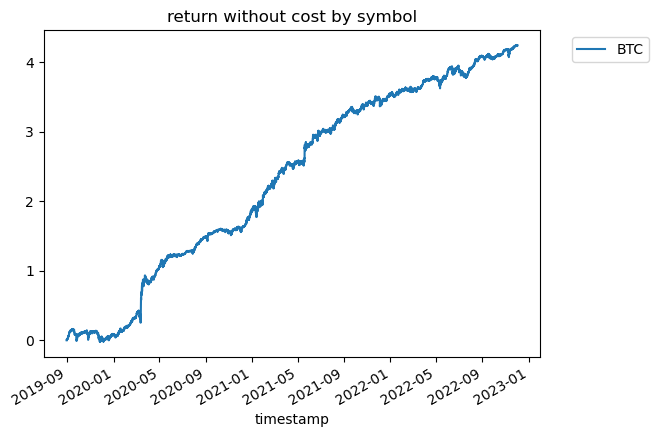

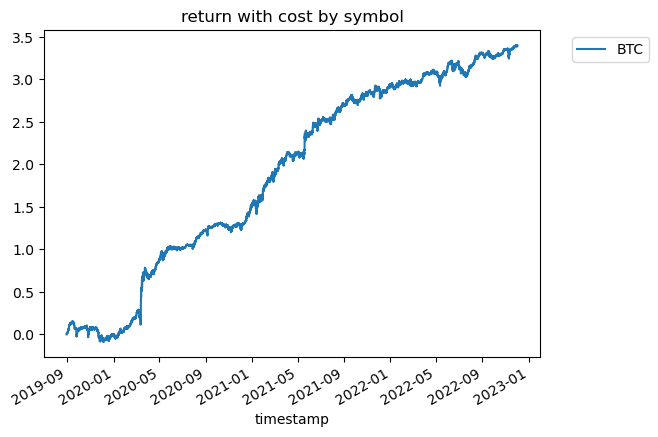

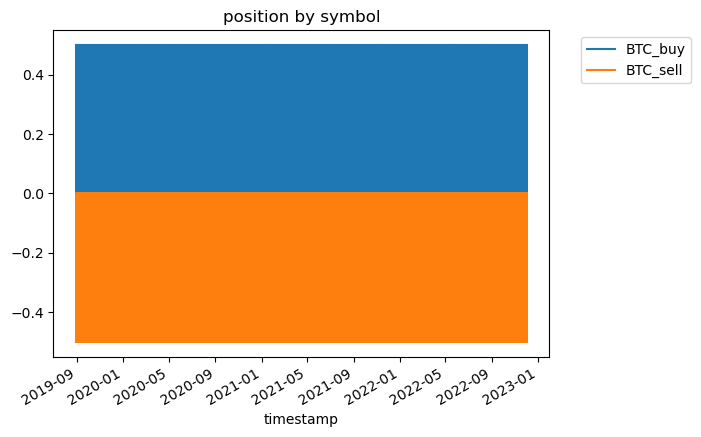

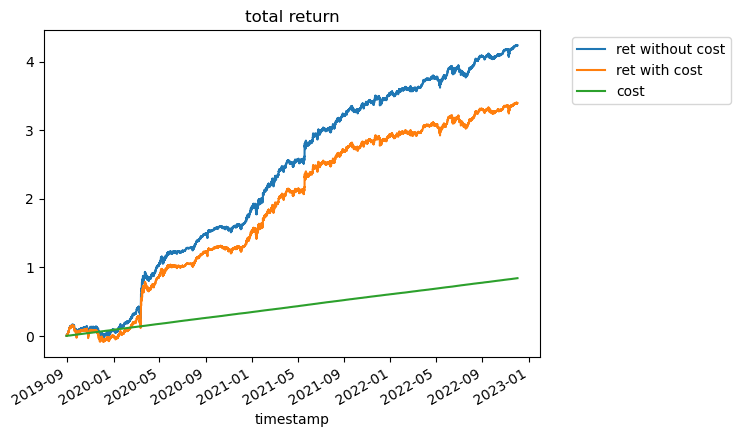

In [22]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_mm.pkl')
df = df.reset_index()
df['execution_start_at'] = df['timestamp']
df = df.set_index(['timestamp', 'symbol'])

model = ExampleModelRank()

# cv
df_cv = calc_position_cv_mm(model, df)
visualize_result_mm(df_cv.dropna(), execution_cost=0.0001)

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

                                  buy_amount  sell_amount  buy_price  \
timestamp                 symbol                                       
2022-11-25 15:50:00+00:00 BTC            0.5          0.0  2287691.0   
2022-11-25 16:50:00+00:00 BTC            0.5          0.5  2291483.0   
2022-11-25 17:50:00+00:00 BTC            0.5          0.5  2290905.0   
2022-11-25 18:50:00+00:00 BTC            0.5          0.5  2296860.0   
2022-11-25 19:50:00+00:00 BTC            0.5          0.0  2299000.0   
...                                      ...          ...        ...   
2022-12-02 11:50:00+00:00 BTC            0.5          0.0  2301749.0   
2022-12-02 12:50:00+00:00 BTC            0.5          0.5  2306683.0   
2022-12-02 13:50:00+00:00 BTC            0.5          0.5  2307399.0   
2022-12-02 14:50:00+00:00 BTC            0.5          0.0  2310904.0   
2022-12-02 15:50:00+00:00 BTC            0.5          0.0  2308847.0   

                                  sell_price  
timestamp       

/tmp/ipykernel_96095/495065475.py:23: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  idx = df_pred1.index & df_pred2.index & df_pred3.index
/tmp/ipykernel_96095/495065475.py:23: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  idx = df_pred1.index & df_pred2.index & df_pred3.index


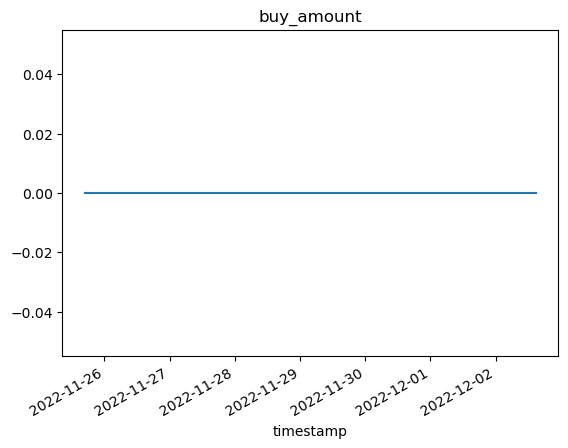

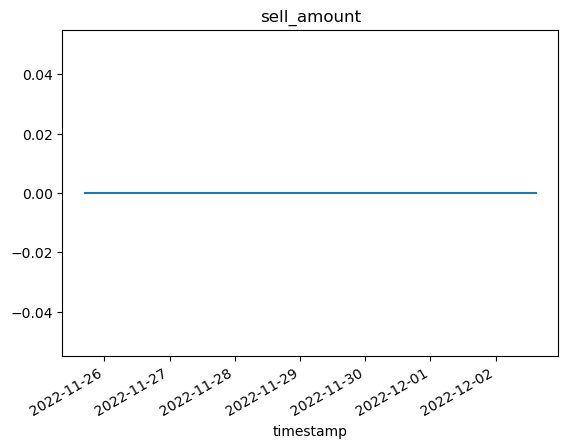

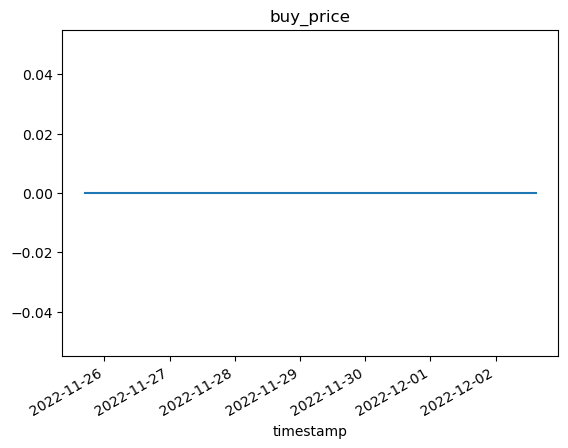

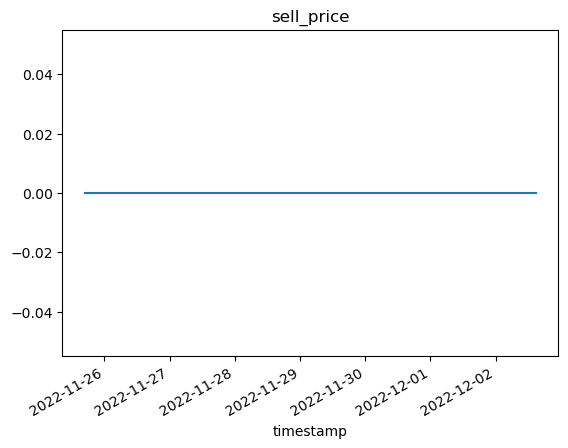

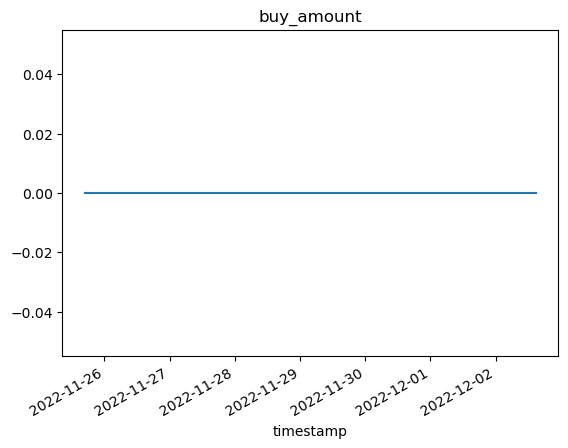

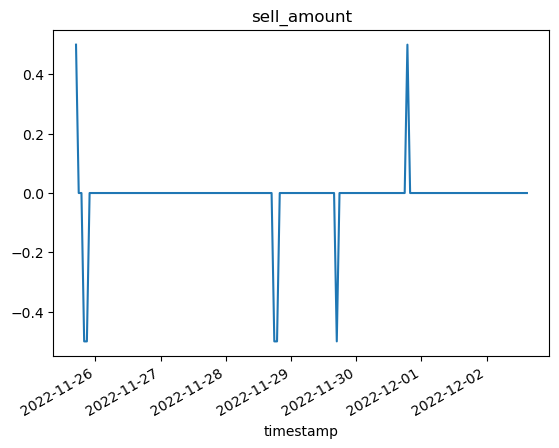

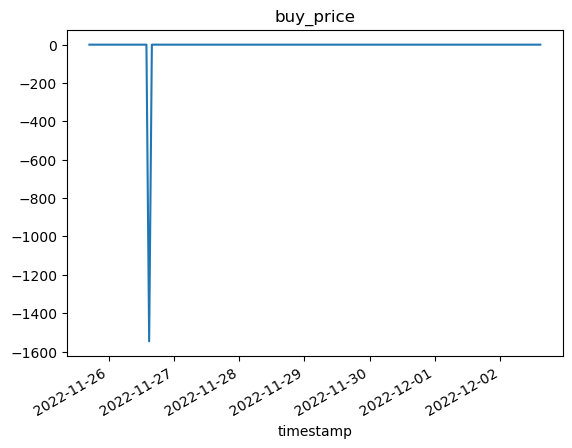

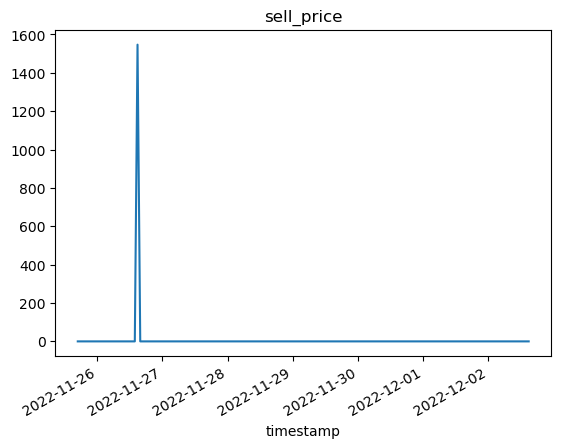

In [11]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_mm.pkl')
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

df_pred1 = model.predict(df)
df_pred2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
df_pred3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

idx = df_pred1.index & df_pred2.index & df_pred3.index
df_pred1 = df_pred1.loc[idx]
df_pred2 = df_pred2.loc[idx]
df_pred3 = df_pred3.loc[idx]

for col in df_pred1.columns:
    for symbol, df_symbol in df_pred1.groupby('symbol'):
        df_symbol = df_symbol.reset_index().set_index('timestamp')
        df_symbol2 = df_pred2.loc[df_symbol.index].reset_index().set_index('timestamp')
        (df_symbol[col] - df_symbol2[col]).plot()
    plt.title(col)
    plt.show()

for col in df_pred1.columns:
    for symbol, df_symbol in df_pred1.groupby('symbol'):
        df_symbol = df_symbol.reset_index().set_index('timestamp')
        df_symbol3 = df_pred3.loc[df_symbol.index].reset_index().set_index('timestamp')
        (df_symbol[col] - df_symbol3[col]).plot()
    plt.title(col)
    plt.show()